## Capstone Project 1 Proposal: Supplier Pricing Prediction 

### Project Scope: 
Caterpillar (construction equipment manufacturer) relies on a variety of suppliers to manufacture tube assemblies for their equipment. These assemblies are required in their equipment to lift, load and transport heavy construction loads. We are provided with detailed tube, component, and annual volume datasets. Our goal is to build and train a model that can predict how much a supplier will quote for a given tube assembly based on given supplier pricing.


In [51]:
#load libraries

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

import seaborn as sns

import glob as gl

from functools import reduce  # ask about this library

import warnings
warnings.filterwarnings('ignore')


In [58]:
# Read multiple files together and concatinating all fileds in to one file: Approach 1

csv_files = gl.glob('*.csv')
print('Number of Files:','\n',len(csv_files),'\n''Filenames:','\n', csv_files)

df_data= []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    df_data.append(df)

df_full= pd.concat(df_data)


Number of Files: 
 21 
Filenames: 
 ['comp_threaded.csv', 'comp_adaptor.csv', 'tube_end_form.csv', 'comp_straight.csv', 'comp_tee.csv', 'comp_boss.csv', 'components.csv', 'comp_float.csv', 'bill_of_materials.csv', 'comp_elbow.csv', 'type_connection.csv', 'train_set.csv', 'comp_sleeve.csv', 'test_set.csv', 'tube.csv', 'comp_hfl.csv', 'type_end_form.csv', 'comp_other.csv', 'type_component.csv', 'specs.csv', 'comp_nut.csv']


In [37]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 128215 entries, 0 to 64
Columns: 116 entries, adaptor_angle to weight
dtypes: float64(57), object(59)
memory usage: 114.4+ MB


In [70]:
#head of BOM table
df_data[8].head()

,tube_assembly_id,component_id_1,quantity_1,component_id_2,quantity_2,component_id_3,quantity_3,component_id_4,quantity_4,component_id_5,quantity_5,component_id_6,quantity_6,component_id_7,quantity_7,component_id_8,quantity_8
0,TA-00001,C-1622,2.0,C-1629,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00002,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00003,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00004,C-1312,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00005,C-1624,1.0,C-1631,1.0,C-1641,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [174]:
df_bom_t.iloc[0:, 3:].head()

,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8
0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
#Melting BOM table
df_bom = df_data[8]
df_bom_melt= df_bom.melt(id_vars='tube_assembly_id',value_vars = ['component_id_1', 'component_id_2','component_id_3','component_id_4','component_id_5','component_id_6','component_id_7','component_id_8'],value_name= 'component_id')
df_bom_t = (df_bom_melt.merge(df_bom, how = 'inner', on = 'tube_assembly_id')).drop(columns= ['component_id_1', 'component_id_2','component_id_3','component_id_4','component_id_5','component_id_6','component_id_7','component_id_8'])
df_bom_t.head()

#df_bom_t.dropna(axis= 'columns', how = 'all')
#(df_bom_t[df_bom_t[3:].isnull()== True]).dropna(how = 'all' ,axis = 'columns')

,tube_assembly_id,variable,component_id,quantity_1,quantity_2,quantity_3,quantity_4,quantity_5,quantity_6,quantity_7,quantity_8
0,TA-00001,component_id_1,C-1622,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
1,TA-00001,component_id_2,C-1629,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
2,TA-00001,component_id_3,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,TA-00001,component_id_4,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4,TA-00001,component_id_5,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


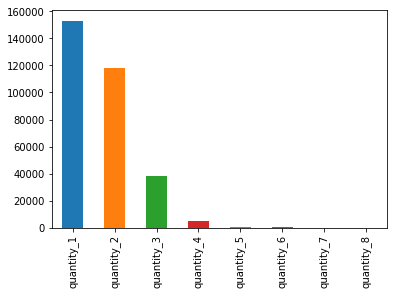

In [197]:
df_bom_t.iloc[0:, 3:].notnull().sum().plot(kind='bar')

### Join datasets using Primary Key: Tube_Assembly_Id

In [246]:
#load dataset for Tube (df_t), Bill of Material(df_b), Specs (df_s) and set tube_assembly_id as index

df_t = pd.read_csv('tube.csv', index_col='tube_assembly_id')
df_b = pd.read_csv('bill_of_materials.csv', index_col='tube_assembly_id')
df_s = pd.read_csv('specs.csv', index_col='tube_assembly_id')
df_tr= pd.read_csv('train_set.csv', index_col='tube_assembly_id', parse_dates=True) 


In [295]:
#Join loaded datasets along common index tube_assembly_id using left join.

df_tb = df_t.join(other = df_b, on ='tube_assembly_id', how='left')
df_tbs = df_tb.join(other = df_s, on ='tube_assembly_id', how= 'left')
df_primary = df_tbs.join(other = df_tr, on ='tube_assembly_id', how= 'left')          
df_primary.head()

,material_id,diameter,wall,length,num_bends,bend_radius,end_a_1x,end_a_2x,end_x_1x,end_x_2x,...,spec8,spec9,spec10,supplier,quote_date,annual_usage,min_order_quantity,bracket_pricing,quantity,cost
tube_assembly_id,,,,,,,,,,,,,,,,,,,,,
TA-00001,SP-0035,12.70,1.65,164.0,5,38.10,N,N,N,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,...,NaN,NaN,NaN,S-0066,2013-07-07,0.0,0.0,Yes,1.0,21.905933
TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,...,NaN,NaN,NaN,S-0066,2013-07-07,0.0,0.0,Yes,2.0,12.341214
TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,...,NaN,NaN,NaN,S-0066,2013-07-07,0.0,0.0,Yes,5.0,6.601826
TA-00002,SP-0019,6.35,0.71,137.0,8,19.05,N,N,N,N,...,NaN,NaN,NaN,S-0066,2013-07-07,0.0,0.0,Yes,10.0,4.687770


In [336]:
column = df_primary.columns.drop('cost')
df_primary_pivot = df_primary.pivot_table(index= 'tube_assembly_id', 
                                          columns = ['material_id'],
                                          values= ['cost'], 
                                          aggfunc='mean')
df_primary_pivot=df_primary_pivot.transpose()
df_primary_pivot

tube_assembly_id  TA-00002  TA-00004   TA-00005  TA-00012   TA-00013  \
     material_id                                                       
cost SP-0008           NaN       NaN        NaN       NaN        NaN   
     SP-0019      7.298036  7.364806        NaN       NaN        NaN   
     SP-0028           NaN       NaN        NaN       NaN  10.004284   
     SP-0029           NaN       NaN  10.251888       NaN        NaN   
     SP-0030           NaN       NaN        NaN       NaN        NaN   
     SP-0031           NaN       NaN        NaN       NaN        NaN   
     SP-0032           NaN       NaN        NaN       NaN        NaN   
     SP-0033           NaN       NaN        NaN       NaN        NaN   
     SP-0034           NaN       NaN        NaN       NaN        NaN   
     SP-0035           NaN       NaN        NaN       NaN        NaN   
     SP-0036           NaN       NaN        NaN       NaN        NaN   
     SP-0037           NaN       NaN        NaN       NaN        NaN   
     SP-0038           NaN       NaN        NaN       NaN        NaN   
     SP-0039           NaN       NaN        NaN  7.808892        NaN   
     SP-0041           NaN       NaN        NaN       NaN        NaN   
     SP-0046           NaN       NaN        NaN       NaN        NaN   
     SP-0048           NaN       NaN        NaN       NaN        NaN   

tube_assembly_id  TA-00014  TA-00021  TA-00022  TA-00024  TA-00025    ...      \
     material_id                                                      ...       
cost SP-0008           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0019           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0028           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0029      7.388106       NaN       NaN       NaN       NaN    ...       
     SP-0030           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0031           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0032           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0033           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0034           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0035           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0036           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0037           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0038           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0039           NaN       NaN  8.563178  6.329184  6.175476    ...       
     SP-0041           NaN  3.433061       NaN       NaN       NaN    ...       
     SP-0046           NaN       NaN       NaN       NaN       NaN    ...       
     SP-0048           NaN       NaN       NaN       NaN       NaN    ...       

tube_assembly_id  TA-21183  TA-21184   TA-21185   TA-21186  TA-21189  \
     material_id                                                       
cost SP-0008           NaN       NaN        NaN        NaN       NaN   
     SP-0019           NaN       NaN        NaN        NaN       NaN   
     SP-0028           NaN  5.959171        NaN        NaN       NaN   
     SP-0029           NaN       NaN  71.212366  28.585657       NaN   
     SP-0030           NaN       NaN        NaN        NaN       NaN   
     SP-0031           NaN       NaN        NaN        NaN       NaN   
     SP-0032           NaN       NaN        NaN        NaN       NaN   
     SP-0033           NaN       NaN        NaN        NaN       NaN   
     SP-0034           NaN       NaN        NaN        NaN       NaN   
     SP-0035      5.925786       NaN        NaN        NaN  8.540458   
     SP-0036           NaN       NaN        NaN        NaN       NaN   
     SP-0037           NaN       NaN        NaN        NaN       NaN   
     SP-0038           NaN       NaN        NaN        NaN       NaN   
     SP-003

## Join datasets using Secondary Key: Component_Id

In [151]:
#load component tables and join along seconday key component_id 
tables = ['components.csv',
          'comp_adaptor.csv',
          'comp_boss.csv', 
          'comp_elbow.csv',
          'comp_float.csv', 
          'comp_hfl.csv', 
          'comp_nut.csv', 
          'comp_other.csv', 
          'comp_sleeve.csv', 
          'comp_straight.csv', 
          'comp_tee.csv', 
          'comp_threaded.csv']

df_comps = [pd.read_csv(table, index_col='component_id') for table in tables]

#code idea from stackoverflow
#df_0_11= df_comps[0].join(df_comps[1:], on='component_id', how = 'left').....class type error
#df_comps= reduce(lambda left,right: pd.merge(left,right,on='component_id'), tables)

In [227]:
#Join various component types along common index component_id using left join.
df_0_1= df_comps[0].merge(df_comps[1], on = 'component_id', how = 'left')
df_0_2  = df_0_1.merge(df_comps[2], on = 'component_id', how = 'left')
df_0_3  = df_0_2.merge(df_comps[3], on = 'component_id', how = 'left')
df_0_4  = df_0_3.merge(df_comps[4], on = 'component_id', how = 'left')
df_0_5  = df_0_4.merge(df_comps[5], on = 'component_id', how = 'left')
df_0_6  = df_0_5.merge(df_comps[6], on = 'component_id', how = 'left')
df_0_7  = df_0_6.merge(df_comps[7], on = 'component_id', how = 'left')
df_0_8  = df_0_7.merge(df_comps[8], on = 'component_id', how = 'left')
df_0_9  = df_0_8.merge(df_comps[9], on = 'component_id', how = 'left')
df_0_10  = df_0_9.merge(df_comps[10], on = 'component_id', how = 'left')
df_0_11  = df_0_10.merge(df_comps[11], on = 'component_id', how = 'left')


In [228]:
df_comps[1].head()

,component_type_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,connection_type_id_2,length_2,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight
component_id,,,,,,,,,,,,,,,,,,,
C-0005,CP-028,NaN,58.4,A-001,B-001,NaN,1.312,12.0,NaN,A-001,B-004,NaN,1.000,11.5,NaN,34.93,No,No,0.206
C-0006,CP-028,NaN,34.8,A-001,B-001,NaN,0.437,20.0,NaN,A-001,B-005,NaN,0.750,16.0,NaN,22.20,No,No,0.083
C-1435,CP-028,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,B-007,NaN,0.875,18.0,NaN,22.22,No,No,0.023
C-1546,CP-028,NaN,26.4,A-007,B-004,NaN,0.125,27.0,NaN,A-001,B-004,NaN,0.125,27.0,NaN,15.88,No,No,0.026
C-1583,CP-028,NaN,44.5,A-001,B-005,NaN,1.312,12.0,NaN,A-007,B-005,NaN,1.062,12.0,NaN,38.10,No,No,0.256


In [215]:
# Load component types and map component, connection and end types of the tube assembly

df_comp_type = pd.read_csv('type_component.csv', index_col='component_type_id')
df_connection_type = pd.read_csv('type_connection.csv', index_col='connection_type_id')
df_end_type = pd.read_csv('type_end_form.csv', index_col='end_form_id')

In [216]:
df_test=df_0_11.merge(df_comp_type, on ='component_type_id', how = 'left')

In [217]:
df_0_11.reset_index().head().columns

Index(['component_id', 'name', 'component_type_id_x', 'component_type_id_y',
       'adaptor_angle_x', 'overall_length_x', 'end_form_id_1_x',
       'connection_type_id_1_x', 'length_1_x', 'thread_size_1_x',
       ...
       'nominal_size_3', 'end_form_id_4', 'connection_type_id_4', 'length_4',
       'thread_size_4', 'thread_pitch_4', 'nominal_size_4', 'unique_feature',
       'orientation_y', 'weight'],
      dtype='object', length=141)

In [244]:
df_0_11.head()

,name,component_type_id_x,component_type_id_y,adaptor_angle_x,overall_length_x,end_form_id_1_x,connection_type_id_1_x,length_1_x,thread_size_1_x,thread_pitch_1_x,...,nominal_size_3,end_form_id_4,connection_type_id_4,length_4,thread_size_4,thread_pitch_4,nominal_size_4,unique_feature,orientation_y,weight
component_id,,,,,,,,,,,,,,,,,,,,,
9999,OTHER,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0001,SLEEVE,CP-024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0002,SLEEVE,CP-024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0003,SLEEVE-FLARED,CP-024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C-0004,NUT,CP-026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [245]:
df_comps[1].head()

,component_type_id,adaptor_angle,overall_length,end_form_id_1,connection_type_id_1,length_1,thread_size_1,thread_pitch_1,nominal_size_1,end_form_id_2,connection_type_id_2,length_2,thread_size_2,thread_pitch_2,nominal_size_2,hex_size,unique_feature,orientation,weight
component_id,,,,,,,,,,,,,,,,,,,
C-0005,CP-028,NaN,58.4,A-001,B-001,NaN,1.312,12.0,NaN,A-001,B-004,NaN,1.000,11.5,NaN,34.93,No,No,0.206
C-0006,CP-028,NaN,34.8,A-001,B-001,NaN,0.437,20.0,NaN,A-001,B-005,NaN,0.750,16.0,NaN,22.20,No,No,0.083
C-1435,CP-028,NaN,20.3,A-007,B-004,NaN,NaN,NaN,15.88,A-001,B-007,NaN,0.875,18.0,NaN,22.22,No,No,0.023
C-1546,CP-028,NaN,26.4,A-007,B-004,NaN,0.125,27.0,NaN,A-001,B-004,NaN,0.125,27.0,NaN,15.88,No,No,0.026
C-1583,CP-028,NaN,44.5,A-001,B-005,NaN,1.312,12.0,NaN,A-007,B-005,NaN,1.062,12.0,NaN,38.10,No,No,0.256


,name
component_type_id,
CP-001,4-bolt Tig Straight
CP-002,4-bolt MJ Straight
CP-003,4-bolt Braze/Weld Straight
CP-004,2-bolt Braze/Weld Straight
CP-005,2-bolt MJ Straight
